In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time

from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
from sklearn.neighbors import KernelDensity
import statsmodels.api as sma

from scipy.integrate import quad
from scipy.interpolate import interp1d

from SyntheticDataModule import *
from IHDPDataModule import *
from estimators import *
from utils import *
from mmr_utils import *

<Axes: >

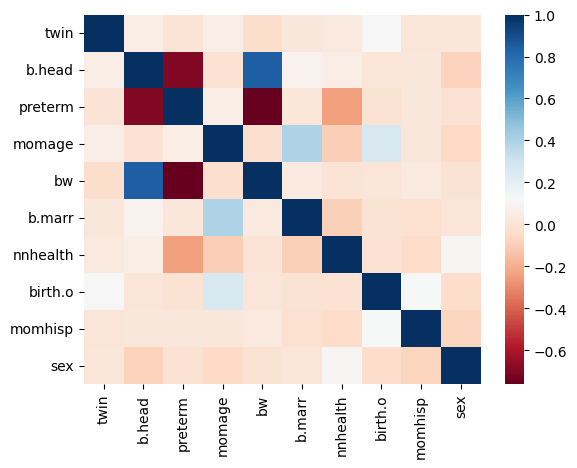

In [2]:
ORIG_COL_NAMES = ["twin", "b.head", "preterm", "momage", "bw", "b.marr", "nnhealth", "birth.o", "momhisp", "sex"]
CONT_COLS = ["b.head", "preterm", "momage", "bw", "nnhealth", "birth.o"]
DISC_COLS = ["twin", "b.marr", "momhisp", "sex"]
COL_NAME_DICT = {f"X{i+1}": col  for i,col in enumerate(ORIG_COL_NAMES)}

ihdp_df = pd.read_csv('data/ihdp/ihdp.csv')[ORIG_COL_NAMES]

scaler = MinMaxScaler()
ihdp_df[CONT_COLS] = scaler.fit_transform(ihdp_df[CONT_COLS])
ihdp_df[DISC_COLS] = ihdp_df[DISC_COLS] - 0.5

sns.heatmap(ihdp_df.corr(), cmap='RdBu')

RCT size: 985, OS size: 1970, time elapsed: 157.13


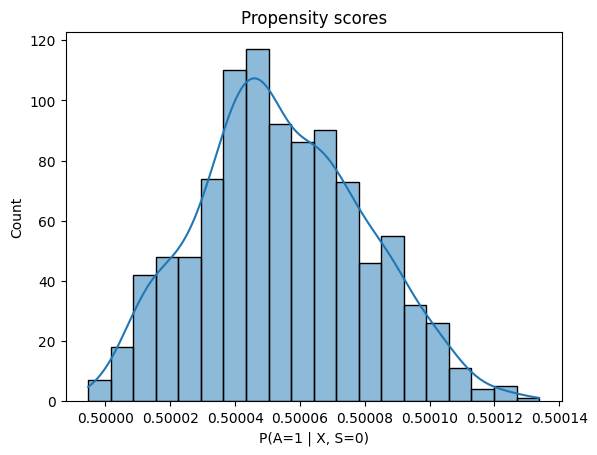

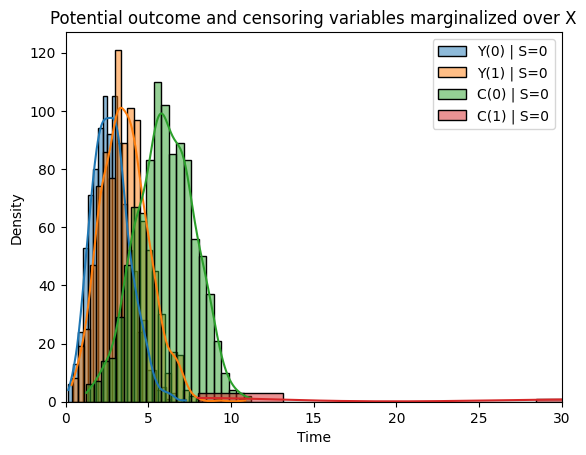

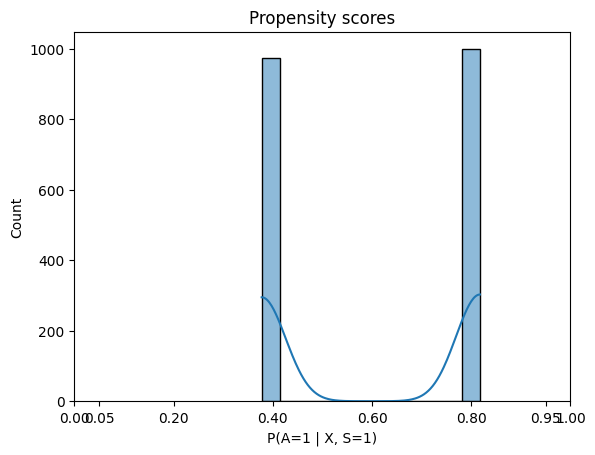

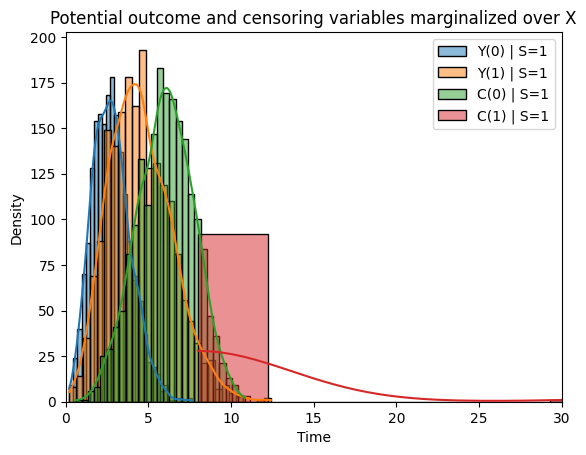

In [7]:
mmr_keys = ["IPCW", "IPW-Drop"]
CD = 10
UC = 0
jD = read_json('ihdp/diffPOihdp-highdiff_GC.json', CD, UC, mmr_keys)

m = 2
os_size = int(jD['rct_size'] * m)

t1 = time()

df_combined, df_comb_drop, RCTData, OSData = generate_data(CD, os_size, jD)
Fb_Y, Gb_C = est_nuisance(df_combined, df_comb_drop, jD)

print('RCT size: {}, OS size: {}, time elapsed: {:.2f}'.format(jD['rct_size'], os_size, time() - t1))

summary_df = pd.concat([RCTData.summary(plot=True), OSData.summary(plot=True)], axis=0, ignore_index=True)
summary_df

crop_prop = True

mmr_stats = np.zeros((len(mmr_keys), 2))  # store results and p-val for each mmr test

# for kind, key in enumerate(mmr_keys):
#     if 'Drop' in key:
#         df_mmr = df_comb_drop.copy()
#     else:
#         df_mmr = df_combined.copy()

#     if jD['crop_prop'] and ('Drop' not in key):
#         df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
#                 (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95) &\
#                 (1e-4 < df_mmr['Gb(T|X,S,A)'])].copy().reset_index(drop=True)

#     if jD['crop_prop'] and ('Drop' in key):
#         df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
#                 (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95)].copy().reset_index(drop=True)

#     signal0, signal1 = jD['test_signals'][key][0], jD['test_signals'][key][1]
#     mmr_stats[kind, 0], mmr_stats[kind, 1] = mmr_test(df_mmr, jD['cov_list'], jD['B'], laplacian_kernel, signal0, signal1)

In [6]:
df_combined['Gb(T|X,S,A)'].min()

0.17878223488468414

In [ ]:
for xname in COL_NAME_DICT.keys():
    plot_wit_fn(df_combined, laplacian_kernel, xname, "S0_cdr_Miss_None_est_CATE", "S1_cdr_Miss_None_est_CATE", plot_marg=False, weight_marg=True)
    plot_wit_fn(df_combined, laplacian_kernel, xname, "S0_cdr_Miss_None_est_CATE", "S1_cdr_Miss_None_est_CATE", plot_marg=True, weight_marg=False)

In [ ]:
np.clip([0.4,0.7], a_max=1000, a_min=0.5)

In [ ]:
data = np.array(df_combined['X10'])
dens = sma.nonparametric.KDEUnivariate(data)
dens.fit()
x = np.linspace(0,1,100) #restrict range to (0,1)
y = dens.evaluate(data)

In [ ]:
dens.evaluate(data).shape

In [ ]:
mmr_stats

In [ ]:
def calc_wit_fn(df, kernel, x_name, x_arr, signal0, signal1, weight_marg=True):
    kxx = kernel(x_arr.reshape(-1,1), np.array(df[x_name]).reshape(-1,1))
    psi = np.array(df[signal1] - df[signal0])
    
    if weight_marg:
        data = np.array(df[x_name])
        dens = sma.nonparametric.KDEUnivariate(data)
        dens.fit()
        #pdb.set_trace()
        return (kxx @ psi) / (len(psi) * np.clip(dens.evaluate(x_arr), a_max=1000, a_min=0.5)) , kxx, psi
    else:
        return (kxx @ psi) / len(psi), kxx, psi

def plot_wit_fn(df, kernel, x_name, signal0, signal1, plot_marg=False, weight_marg=True):
    plt.figure()
    if COL_NAME_DICT[x_name] in DISC_COLS:
        x_arr = np.array([-0.5,0.5])
        wit_fn,_,_ = calc_wit_fn(df, kernel, x_name, x_arr, signal0, signal1, weight_marg)
        plt.scatter(x_arr + 0.5, wit_fn)
    else:
        x_arr = np.linspace(0,1,101)
        wit_fn,_,_ = calc_wit_fn(df, kernel, x_name, x_arr, signal0, signal1, weight_marg)
        plt.plot(x_arr, wit_fn)
        
    plt.xlabel(COL_NAME_DICT[x_name])
    plt.ylabel('Witness function')
    plt.show()
    
    if plot_marg:
        plt.figure()
        plt.hist(df[x_name])
        plt.xlabel(COL_NAME_DICT[x_name])

In [ ]:
mis_spec = 'Fb'
cov_vals = np.zeros(CD+1)

s, a = 0,1
x = np.zeros(CD + 1)
key
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}_true']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = ty #
st_arr = sty  

func = interp1d(t_arr, st_arr, kind='linear', fill_value='extrapolate')

xnew = np.arange(0, t_arr.max(), 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
tbs_Y = RCTData.get_oracle_surv_curve(t_arr, cov_vals, f'Y{a}')

plt.figure()
plt.plot(t_arr, tbs_Y, label=f'true Y{a}', ls ='-.', alpha= 0.4)
plt.plot(t_arr, st_arr, label='est', ls='-', alpha= 0.4)
plt.plot(xnew, ynew, label='func approx', ls='--', alpha= 0.4)
plt.legend()
plt.show()

# Trange = tc.copy()

# t1 = time()
# q_arr = eval_Qfunc_arr_(s, a, x, Trange, Fb_Y, mis_spec)
# print(f"Time: {time() - t1}")
# plt.figure()
# plt.plot(Trange, q_arr)
# plt.show()

In [ ]:
t_arr

In [ ]:
mis_spec = 'None'
cov_vals = np.array([0,0, 1, 0, 1, 1, 0, 1, 1, 1 ,1])
cov_vals = np.zeros(11)


s, a = 1,1
x = np.zeros(CD + 1)
key
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = tc #
st_arr = stc  

func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')

ynew = func(t_arr)   # use interpolation function returned by `interp1d`
tbs_C = OSData.get_oracle_surv_curve(t_arr, cov_vals, f'C{a}')

plt.figure()
plt.plot(t_arr, tbs_C, label=f'true C{a}', ls ='-.', alpha= 0.4)
plt.plot(t_arr, st_arr, label='est', ls='-', alpha= 0.4)
plt.plot(t_arr, ynew, label='func approx', ls='--', alpha= 0.4)
plt.legend()
plt.show()

# Trange = tc.copy()

# t1 = time()
# q_arr = eval_Qfunc_arr_(s, a, x, Trange, Fb_Y, mis_spec)
# print(f"Time: {time() - t1}")
# plt.figure()
# plt.plot(Trange, q_arr)
# plt.show()

In [ ]:
row = 2088

s = df_combined.loc[row, 'S']
a = df_combined.loc[row, 'A']
x = np.array(df_combined.loc[row, jD['cov_list']])
T = df_combined.loc[row, 'T']
Delta = df_combined.loc[row, 'Delta']

df_combined.loc[row]

In [ ]:
np.array([1,1]) @ 0

In [ ]:
row = 922

s = df_mmr.loc[row, 'S']
a = df_mmr.loc[row, 'A']
x = np.array(df_combined.loc[row, jD['cov_list']])
T = df_mmr.loc[row, 'T']
Delta = df_mmr.loc[row, 'Delta']

df_mmr.loc[row]

In [ ]:
mis_spec = 'None'

In [ ]:
eval_surv_(Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}'], T)

In [ ]:
eval_int_term_(s, a, x, T, Gb_C, Fb_Y, mis_spec)

In [ ]:
eval_Ystar_(s, a, x, Delta, T, Gb_C, Fb_Y, mis_spec)

In [ ]:
eval_Qfunc_(s, a, x, T, Fb_Y, mis_spec)

In [ ]:
eval_mu_(s, 1, x, Fb_Y, mis_spec)

In [ ]:
s, a = 0, 0
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = tc #
st_arr = stc  

t1 = time()
func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')
result, error = quad(func, 0, t_arr.max() + 10, limit=5)

print(f"Time: {time()-t1:.2f} s.")
print(f"Result of integration: {result}, error: {error}")

xnew = np.arange(0, t_arr.max(), 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(t_arr, st_arr, 'o', xnew, ynew, '--')
plt.show()

In [ ]:
pv = np.load('results/ihdp/samePOihdp/CD-10/UC-1/pvals.npy')
#csv = pd.read_csv('results/complete-IC/samePO/CD-10/UC-0/res_summary.csv')

np.mean(pv[2], axis=1)

In [ ]:
for s in range(2):
    for a in range(2):
        print('-----\n-----')
        #df = df_combined.query(f"S == {s} & A == {a}").copy()  # all data
        df = df_mmr.query(f"S == {s} & A == {a}").copy()       # goes into MMR (after cropping etc.)

        Ystar_No_miss = f'S{s}_Ystar{a}_Miss_None_est_CATE'
        Ystar_Fb_miss = f'S{s}_Ystar{a}_Miss_Fb_est_CATE'
        Ystar_Gb_miss = f'S{s}_Ystar{a}_Miss_Gb_est_CATE'
        
        mu_No_miss = f'S{s}_muxsa{a}_Miss_None_est_CATE'
        mu_Fb_miss = f'S{s}_muxsa{a}_Miss_Fb_est_CATE'
        mu_Gb_miss = f'S{s}_muxsa{a}_Miss_Gb_est_CATE'

        print("E[Y|S={}, A={}]: {:.2f}".format(s ,a, df[f'Y{a}'].mean()))
        print("E[Ystar_No_miss|S={}, A={}]: {:.2f}".format(s, a, df[Ystar_No_miss].mean()))
        print("E[Ystar_Fb_miss|S={}, A={}]: {:.2f}".format(s, a, df[Ystar_Fb_miss].mean()))
        print("E[Ystar_Gb_miss|S={}, A={}]: {:.2f}".format(s, a, df[Ystar_Gb_miss].mean()))
        print("E[mu_No_miss|S={}, A={}]: {:.2f}".format(s, a, df[mu_No_miss].mean()))
        print("E[mu_Fb_miss|S={}, A={}]: {:.2f}".format(s, a, df[mu_Fb_miss].mean()))
        print("E[mu_Gb_miss|S={}, A={}]: {:.2f}".format(s, a, df[mu_Gb_miss].mean()))

In [ ]:
x_space = np.linspace(-10,10,401)
cov_name = 'X1'
os_oracle_prop = OSData.calc_oracle_prop(x_space, cov_name)
plt.figure()
plt.plot(x_space, os_oracle_prop)
plt.xlabel(cov_name)
plt.ylabel(f'P(A=1|{cov_name},S=1)')
plt.title(f'Oracle propensity score in study S=1 wrt covariate {cov_name}')
plt.show()

t = np.linspace(0,20,101)
cov_vals = [0, 0, 0, 0]
tbs_Y0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y0')
tbs_Y1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y1')
tbs_C0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C0')
tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')
plt.figure()
plt.plot(t, tbs_Y0, label='Y0', alpha= 0.4, ls ='--')
plt.plot(t, tbs_Y1, label='Y1', alpha= 1, ls ='-.')
plt.plot(t, tbs_C0, label='C0', alpha= 0.4)
plt.plot(t, tbs_C1, label='C1', alpha= 0.4)
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()